# Experiment of Housing prices dataset

Obtained from: 
https://my.spindices.com/indices/real-estate/sp-corelogic-case-shiller-20-city-composite-home-price-nsa-index

In [1]:
# execute if not installed
import sys
sys.path.insert(0, '../')

import mogptk

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

%reload_ext autoreload
%autoreload 2

In [2]:
# plot config
sns.set_context('paper', font_scale=1.3)
sns.set_style('ticks')
plt.rcParams['figure.figsize'] = (10, 5)

### Load dataset

In [3]:
# load dataset 
cols = ['Chicago', 'Phoenix', 'Los Angeles', 'San Diego', 'New York', 'San Francisco']

df = pd.read_csv('data/finance_datasets/housing_prices_usa/housing_dataset.csv',
                 skiprows=7,
                 names=cols)
df = df.iloc[:-4]
df.index = pd.to_datetime(df.index)

df['Month'] = np.round(((df.index - df.index[0]) / np.timedelta64(1, 'M')).values)
df.head()

,Chicago,Phoenix,Los Angeles,San Diego,New York,San Francisco,Month
2009-05-01,123.73,103.56,159.18,145.06,171.17,120.16,0.0
2009-06-01,124.99,104.73,160.90,147.31,172.34,124.70,1.0
2009-07-01,128.32,106.66,163.97,150.99,173.91,128.86,2.0
2009-08-01,130.55,108.41,166.62,153.34,175.13,132.47,3.0
2009-09-01,132.13,109.26,168.03,154.76,174.81,134.16,4.0


### Data

In [4]:
data = []

for i, c in enumerate(cols):
    x = df['Month'].values
    y = df[c].values

    data.append(mogptk.Data(x.reshape(-1, 1), y))
    
    stop = int(len(df) * 0.9)
    if i > 0:
        data[i].remove_range(df['Month'][stop], None)
        data[i].remove_randomly(pct=0.3)
    else:
        data[i].remove_range(df['Month'][-1], None)
    data[i].transform(mogptk.TransformDetrend)
    
x_test = [channel.X[~channel.mask] for channel in data]
y_test = [df[cols[i]].values[~data[i].mask] for i in range(len(cols))]

## MOSM

In [5]:
n_trials = 2

mosm_mae = np.zeros((n_trials, len(cols)))
mosm_mape = np.zeros((n_trials, len(cols)))
mosm_rmse = np.zeros((n_trials, len(cols)))

for n in range(n_trials):
    print('Trial ', n)
    model = mogptk.MOSM(data, Q=5)
    # model.init_params('SM')
    
    model.train(method='L-BFGS-B', maxiter=3000, tol=1e-50)
    
    error = mogptk.test_errors(model, x_test=x_test, y_test=y_test)
    
    mosm_mae[n, :] = np.array(error[0])[:, 0]
    mosm_mape[n, :] = np.array(error[0])[:, 1]
    mosm_rmse[n, :] = np.array(error[0])[:, 2]

pd.DataFrame(np.c_[mosm_mae.mean(0), mosm_mape.mean(0), mosm_rmse.mean(0),
                             mosm_mae.std(0), mosm_mape.std(0), mosm_rmse.std(0)],
                       columns=['MAE', 'MAPE', 'RMSE', 'MAE std', 'MAPE% std', 'RMSE std'])

Trial  0
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 520.686230
  Number of iterations: 3000
  Number of functions evaluations: 3359
Done in  12.564225196838379  minutes
Trial  1
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 522.439228
  Number of iterations: 3000
  Number of functions evaluations: 3313
Done in  12.892786701520285  minutes


,MAE,MAPE,RMSE,MAE std,MAPE% std,RMSE std
0,0.324966,0.221850,0.324966,0.198363,0.135420,0.198363
1,0.403701,0.255768,0.403701,0.066232,0.043969,0.066232
2,1.605614,0.604234,1.605614,0.098204,0.034635,0.098204
3,1.707979,0.715126,1.707979,0.100946,0.035339,0.100946
4,0.997621,0.516899,0.997621,0.196317,0.100881,0.196317
5,2.266511,1.045324,2.266511,0.118136,0.041842,0.118136


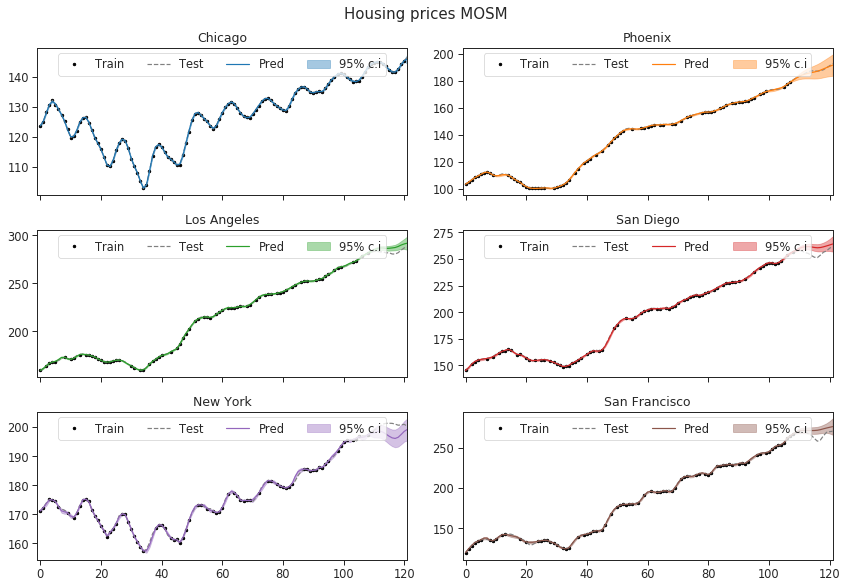

In [6]:
mogptk.plot_prediction(model, grid=(3, 2), names=cols, title='Housing prices MOSM');

## CSM

In [8]:
n_trials = 2

csm_mae = np.zeros((n_trials, len(cols)))
csm_mape = np.zeros((n_trials, len(cols)))
csm_rmse = np.zeros((n_trials, len(cols)))

for n in range(n_trials):
    print('Trial ', n)
    model = mogptk.CSM(data, Q=5)
    # model.init_params()
    
    model.train(method='L-BFGS-B', maxiter=3000, tol=1e-50)
    
    error = mogptk.test_errors(model, x_test=x_test, y_test=y_test)
    
    csm_mae[n, :] = np.array(error[0])[:, 0]
    csm_mape[n, :] = np.array(error[0])[:, 1]
    csm_rmse[n, :] = np.array(error[0])[:, 2]

Trial  0
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 775.806324
  Number of iterations: 3000
  Number of functions evaluations: 3200
Done in  5.016491397221883  minutes
Trial  1
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 773.240129
  Number of iterations: 3000
  Number of functions evaluations: 3222
Done in  4.685006896654765  minutes


NameError: name 'csm_mse' is not defined

In [9]:
pd.DataFrame(np.c_[csm_mae.mean(0), csm_mape.mean(0), csm_rmse.mean(0),
                             csm_mae.std(0), csm_mape.std(0), csm_rmse.std(0)],
                       columns=['MAE', 'MAPE', 'RMSE', 'MAE std', 'MAPE% std', 'RMSE std'])

,MAE,MAPE,RMSE,MAE std,MAPE% std,RMSE std
0,0.300478,0.205133,0.300478,0.024032,0.016406,0.024032
1,0.740517,0.463634,0.740517,0.017323,0.008360,0.017323
2,1.505215,0.597895,1.505215,0.011924,0.000738,0.011924
3,1.645199,0.722234,1.645199,0.029200,0.008764,0.029200
4,1.268073,0.651118,1.268073,0.064811,0.033514,0.064811
5,2.095710,0.973995,2.095710,0.070471,0.031028,0.070471


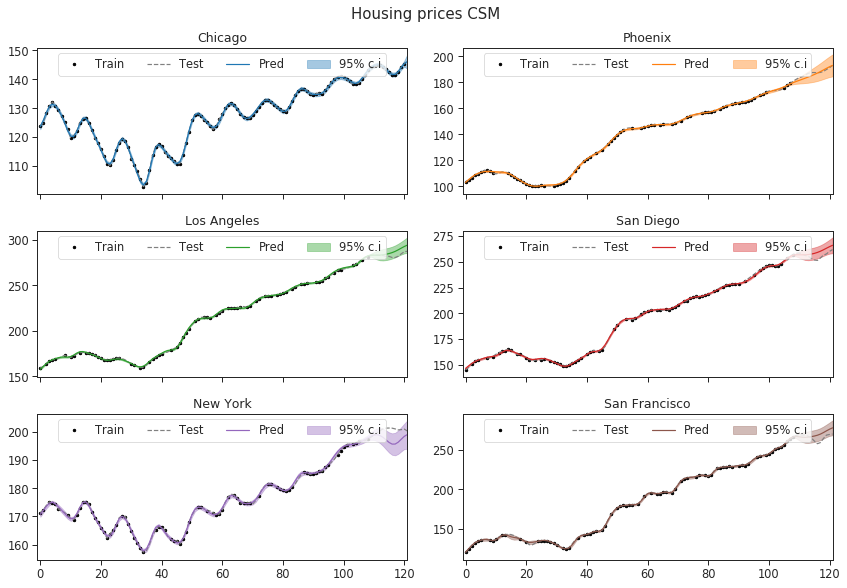

In [11]:
mogptk.plot_prediction(model, grid=(3, 2), names=cols, title='Housing prices CSM');

## SM LMC

In [12]:
n_trials = 2

smlmc_mae = np.zeros((n_trials, len(cols)))
smlmc_mape = np.zeros((n_trials, len(cols)))
smlmc_rmse = np.zeros((n_trials, len(cols)))

for n in range(n_trials):
    print('Trial ', n)
    model = mogptk.SM_LMC(data, Q=5)
    # model.init_params()
    
    model.train(method='L-BFGS-B', maxiter=3000, tol=1e-50)
    
    error = mogptk.test_errors(model, x_test=x_test, y_test=y_test)
    
    smlmc_mae[n, :] = np.array(error[0])[:, 0]
    smlmc_mape[n, :] = np.array(error[0])[:, 1]
    smlmc_rmse[n, :] = np.array(error[0])[:, 2]

pd.DataFrame(np.c_[smlmc_mae.mean(0), smlmc_mape.mean(0), smlmc_rmse.mean(0),
                   smlmc_mae.std(0), smlmc_mape.std(0), smlmc_rmse.std(0)],
             columns=['MAE', 'MAPE', 'RMSE', 'MAE std', 'MAPE% std', 'RMSE std'])

Trial  0
INFO:tensorflow:Optimization terminated with:
  Message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  Objective function value: 772.203048
  Number of iterations: 2742
  Number of functions evaluations: 2961
Done in  3.57833944161733  minutes
Trial  1
INFO:tensorflow:Optimization terminated with:
  Message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  Objective function value: 772.203048
  Number of iterations: 1709
  Number of functions evaluations: 1889
Done in  2.9723302245140077  minutes


,MAE,MAPE,RMSE,MAE std,MAPE% std,RMSE std
0,0.259072,0.176865,0.259072,5.445564e-07,3.717616e-07,5.445564e-07
1,0.764561,0.477917,0.764561,3.750158e-07,1.937348e-07,3.750158e-07
2,1.547042,0.609585,1.547042,5.914236e-07,1.976949e-07,5.914236e-07
3,1.661256,0.731340,1.661256,2.535901e-07,1.016031e-07,2.535901e-07
4,1.304164,0.668673,1.304164,1.115588e-06,5.618957e-07,1.115588e-06
5,2.127719,0.991108,2.127719,5.931934e-09,1.650678e-08,5.931934e-09


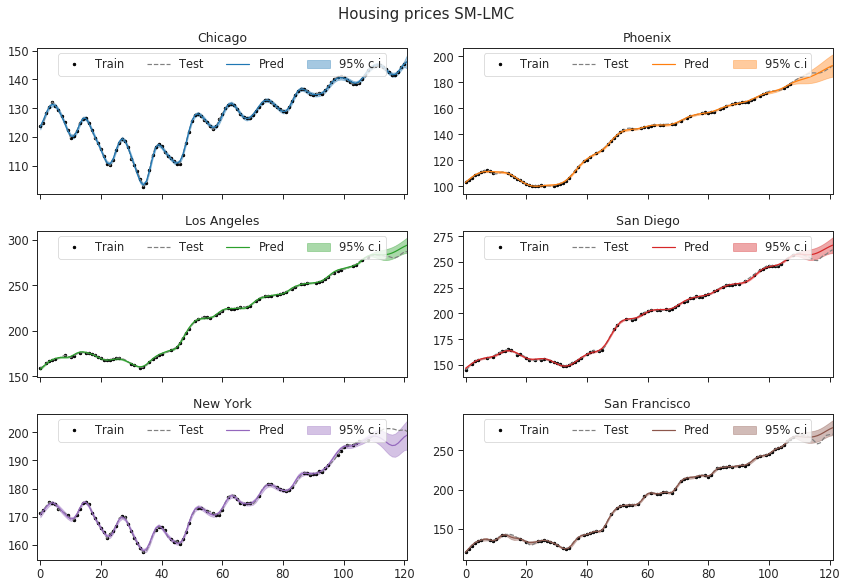

In [13]:
mogptk.plot_prediction(model, grid=(3, 2), names=cols, title='Housing prices SM-LMC');

## CONV

In [14]:
n_trials = 2

conv_mae = np.zeros((n_trials, len(cols)))
conv_mape = np.zeros((n_trials, len(cols)))
conv_rmse = np.zeros((n_trials, len(cols)))

for n in range(n_trials):
    print('Trial ', n)
    model = mogptk.CG(data, Q=5)
    # model.init_params()
    
    model.train(method='L-BFGS-B', maxiter=3000, tol=1e-50)
    
    error = mogptk.test_errors(model, x_test=x_test, y_test=y_test)
    
    conv_mae[n, :] = np.array(error[0])[:, 0]
    conv_mape[n, :] = np.array(error[0])[:, 1]
    conv_rmse[n, :] = np.array(error[0])[:, 2]

pd.DataFrame(np.c_[conv_mae.mean(0), conv_mape.mean(0), conv_rmse.mean(0),
                   conv_mae.std(0), conv_mape.std(0), conv_rmse.std(0)],
             columns=['MAE', 'MAPE', 'RMSE', 'MAE std', 'MAPE% std', 'RMSE std'])

Trial  0
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 1843.742946
  Number of iterations: 628
  Number of functions evaluations: 669
Done in  1.563674839337667  minutes
Trial  1
INFO:tensorflow:Optimization terminated with:
  Message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
  Objective function value: 1843.742946
  Number of iterations: 120
  Number of functions evaluations: 166
Done in  1.1062741875648499  minutes


,MAE,MAPE,RMSE,MAE std,MAPE% std,RMSE std
0,4.421943,3.018804,4.421943,2.093334e-08,1.429092e-08,2.093334e-08
1,3.590500,2.806414,3.590500,2.657409e-09,1.550756e-09,2.657409e-09
2,7.240184,3.819460,7.240184,6.544123e-09,2.545047e-09,6.544123e-09
3,5.961418,3.297077,5.961418,5.559888e-09,2.609090e-09,5.559888e-09
4,5.448873,2.995294,5.448873,2.723026e-10,8.980328e-11,2.723026e-10
5,8.213314,5.112300,8.213314,1.251749e-09,3.157719e-10,1.251749e-09


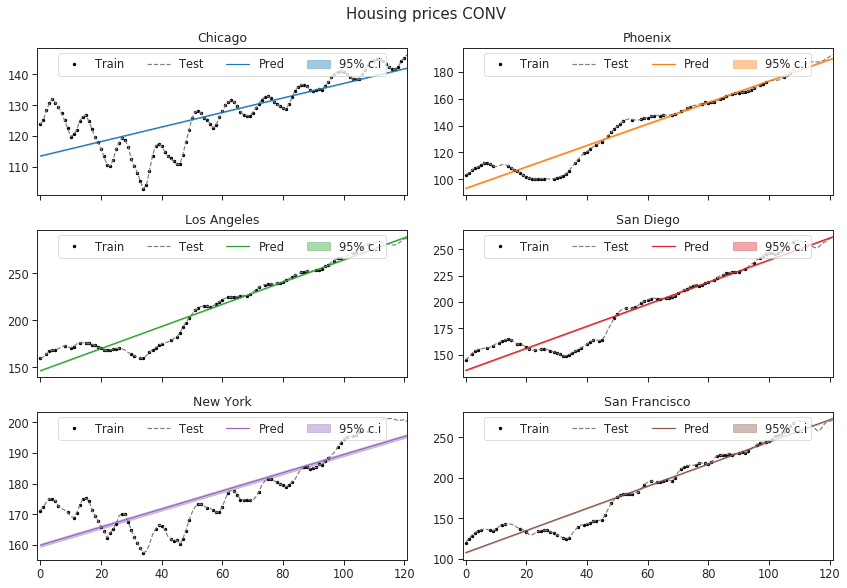

In [15]:
mogptk.plot_prediction(model, grid=(3, 2), names=cols, title='Housing prices CONV');

## Compare all

In [16]:
print(mosm_mae[:, 1:].mean(), csm_mae[:, 1:].mean(), smlmc_mae[:, 1:].mean(), conv_mae[:, 1:].mean())

1.3962852641123302 1.4509428849472468 1.4809485215290412 6.090857852663218


In [17]:
print(mosm_mape[:, 1:].mean(), csm_mape[:, 1:].mean(), smlmc_mape[:, 1:].mean(), conv_mape[:, 1:].mean())

0.6274701191130037 0.6817751780114168 0.6957245173542074 3.6061087066527038


In [18]:
print(mosm_rmse[:, 1:].mean(), csm_rmse[:, 1:].mean(), smlmc_rmse[:, 1:].mean(), conv_rmse[:, 1:].mean())

1.3962852641123302 1.4509428849472468 1.4809485215290412 6.090857852663218
